# Semi Supervised Classification with GAN

Semi-supervised learning is a method of training a classifier that employs both labelled and unlabeled data. This classifier utilises a small amount of labelled data and a large amount of unlabeled data. We will train a Deep CNN using these data sources to learn a function capable to assigning a desired label to a new datapoint.

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/Datasets/Traffic Sign Images

Mounted at /content/drive/
/content/drive/My Drive/Datasets/Traffic Sign Images


Importing necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose, Input
from tensorflow.keras.layers import BatchNormalization,LeakyReLU, Reshape, Dropout, Activation, Lambda
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


## Loading GTSRB Training data

In [3]:
img_dim = 32
n = 43

with open('../data/train.pkl','rb') as f:
    X_train,y_train = pickle.load(f)

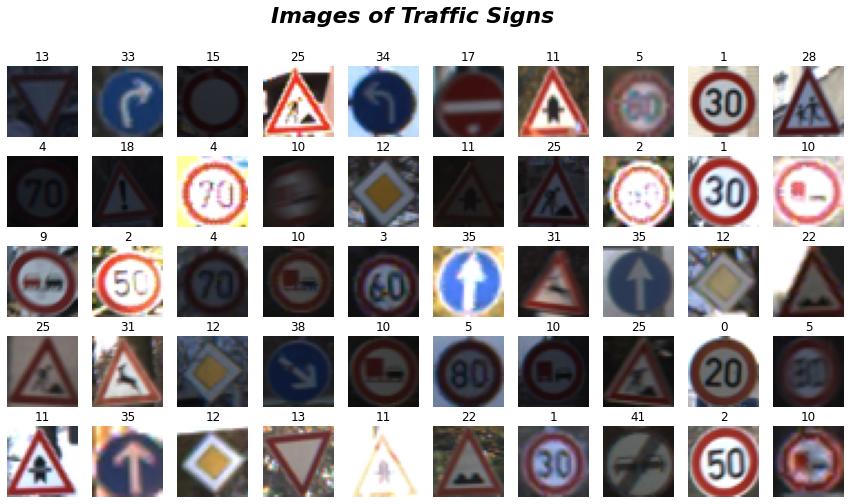

In [4]:
# visualizing some of the images of Traffic Signs
m=len(X_train)
plt.figure(figsize=(15,8))
plt.suptitle('Images of Traffic Signs', fontsize=22, 
             fontweight='bold', fontstyle='italic')

for i in range(50):
    plt.subplot(5,10,i+1)
    ind_ = np.random.randint(0,m)
    plt.imshow(np.array(X_train)[ind_])
    plt.title(y_train[ind_])
    plt.axis('off')
plt.show()

## Preparing data for the Classification
- Scale the images in the range of [-1,1]
- Shuffle the dataset
- Select a supervised subset of the dataset randomly, ensure classes are balanced.
- Helper functions that generate both real and fake samples.

In [5]:
X_train = np.array(X_train).astype('float32')
X_train = (X_train - 127.5) / 127.5
y_train = np.array(y_train)

In [6]:
def shuffle_dataset(X, y):
    assert len(X) == len(y)
    p = np.random.permutation(len(X))
    return X[p], y[p]

X_train, y_train = shuffle_dataset(X_train, y_train)

Semi-supervised learning can be used to train a classifier for a dataset with a small number of labelled instances and a large number of unlabeled instances. Following function will output a small sample of supervised sample which will be fed to the classification model. Every class will be kept balanced.

In [7]:
def get_cls_samples(X, y, samples=1000, classes = 43):
    
    X_cls = []
    Y_cls = []
    
    samples_per_class = samples//classes
    
    for label in range(classes):
        # get all images and labels
        classY = y[y == label]
        classX = X[y == label]
        
        # choose random indexes of X
        indices = np.random.randint(0, len(classX), samples_per_class)
        
        # select random X and y pairs.
        [X_cls.append(classX[idx]) for idx in indices]
        [Y_cls.append(classY[idx]) for idx in indices]
    
    return np.array(X_cls), np.array(Y_cls)

In [8]:
## Create a function that will output the number of supervised samples required to train the classification model, 
## as well as a list of all ones that will be fed to the discriminator.
def get_real_samples(X, labels, samples):
    
    indices = np.random.randint(0, X.shape[0], samples)
    X, label = X[indices], labels[indices]
    y = np.ones((samples,1))
    return [X,label], y



## following function will generate noise of size (noise_dim x samples).
def generate_noise(noise_dim, samples):
    
    noise = np.random.randn(noise_dim * samples)
    noise = noise.reshape(samples, noise_dim)
    return noise



## Compose a function that uses the generator model to generate fake samples and outputs a list of all zeros.
def get_fake_samples(gen_model, noise_dim, samples):
    
    noise = generate_noise(noise_dim, samples)
    gen_images = gen_model.predict(noise)
    y = np.zeros((samples,1))
    return gen_images, y

### Generator
Generator is a reverse CNN. It takes a d-dimensional noise vector and upsamples it to a 32 x 32 x 3 image. To stabilise the outputs of each layer, leaky ReLU is used.
    

In [9]:
def make_generator(noise_dim):
    
    input_ = Input(shape=(noise_dim,))
    
    model = Dense(512*8*8)(input_)
    model = LeakyReLU(0.2)(model)
    model = Reshape((8,8,512))(model)
    
    model = Conv2DTranspose(filters=256, kernel_size=(4,4), strides=(2,2), padding='same')(model)
    model = Dropout(0.3)(model)
    model = LeakyReLU(0.2)(model)

    model = Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same')(model)
    model = LeakyReLU(0.2)(model)
    
    model = Conv2D(filters=3, kernel_size=(7,7), activation='tanh', padding='same')(model)
    gen_model = Model(input_, model)
    return gen_model

In [10]:
noise_dim = 100

make_generator(noise_dim).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      2097408   
 nspose)                                                         
                                                                 
 dropout (Dropout)           (None, 16, 16, 256)       0         
                                                             

### Discriminator

In [11]:
# defining a custom activation function, it will help to determine whether the image is real or fake.

def custom_activation(output):
    logexpsum = backend.sum(backend.exp(output), axis=-1, keepdims=True)
    result = logexpsum / (logexpsum + 1.0)
    return result


# defining the optimizer
def optimizer():
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    return opt

In [12]:
def make_discriminator(input_shape=(img_dim,img_dim,3), classes=n):
    input_ = Input(shape=input_shape)
    
    model = Conv2D(filters=64, kernel_size=(3,3), strides=(2,2),
                     padding='same', input_shape=input_shape)(input_)
    
    model = LeakyReLU(0.2)(model)
    
    for f in [128,256]:
        model = Conv2D(filters=f, kernel_size=(3,3), strides=(2,2), padding='same')(model)
        model = LeakyReLU(0.2)(model)
    model = Flatten()(model)
    model = Dropout(0.4)(model)
    model = Dense(units=classes)(model)
    cls_layer = Activation('softmax')(model)
    cls_model = Model(input_, cls_layer)
    cls_model.compile(loss='sparse_categorical_crossentropy', 
                             optimizer=optimizer(), metrics=['accuracy'])
    
    disc_layer = Lambda(custom_activation)(model)
    disc_model = Model(input_, disc_layer)

    disc_model.compile(loss='binary_crossentropy', optimizer=optimizer())

    return disc_model, cls_model


In [13]:
make_discriminator()[1].summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 4, 4, 256)         0   

### Compiling GAN model

In [14]:
def make_gan(gen_model, disc_model):
    
    # make parameters in discriminator non trainable
    disc_model.trainable = False
    # give the output of generator to the discriminator
    gan_output = disc_model(gen_model.output)
    # define a GAN model. It will take the noise as an input, and will output the classification
    gan = Model(gen_model.input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer())
    return gan

## Training the Semi Supervised GAN
- Use a subset of supervised samples to train a classification layer in discriminator. 
- Train the disc layer by feeding it real and fake samples. If it is unable to distinguish between real and fake images, it will be penalised. 
- Feed the noise to a generator, and it will output the fake images. If the discriminator can distinguish between real and fake images, the generator will be penalised.
- Finally, evaluate the semi-supervised GAN's performance by displaying different evaluating metrics for the classifier. 

In [21]:
def train(models, X, y, noise_dim, epochs=20, batch_size=32):

    gen_model, disc_model, cls_model, gan_model = models
    
    # select 'n' samples of supervised samples from the complete dataset.
    X_cls, y_cls = get_cls_samples(X, y)
    
    # denotes total number of batches that will be trained for one epoch.
    batches_per_epoch = X.shape[0] // batch_size
    
    # calculate total iterations i.e product of batches per epoch and total epochs.
    iters = batches_per_epoch * epochs
    
    for iter_ in range(iters):

        ## training the classification model
        [Xr_cls, yr_cls],_ = get_real_samples(X_cls, y_cls, batch_size//2)
        cls_loss, cls_acc = cls_model.train_on_batch(Xr_cls, yr_cls)
        
        ## train the discriminator
        [Xr_disc,_], yr_disc = get_real_samples(X, y, batch_size//2)
        disc_loss1 = disc_model.train_on_batch(Xr_disc, yr_disc)
        Xf_disc, yf_disc = get_fake_samples(gen_model, noise_dim, batch_size//2)
        disc_loss2 = disc_model.train_on_batch(Xf_disc, yf_disc)
        
        ## train the generator now
        noise = generate_noise(noise_dim, batch_size)
        y_noise = np.ones((batch_size,1))
        gan_loss = gan_model.train_on_batch(noise, y_noise)
        
        ## evaluating the performance of semi-supervised GAN
        if (iter_+1)%batches_per_epoch == 0:
            e = (iter_+1) / batches_per_epoch
            print(f'Epoch # {e}')
            
            evaluate_model(e,cls_model,gen_model, X, y)
            
            print('*'*25)
            print()
            

In [22]:
## helper function for model evaluation..

def evaluate_model(e,cls_model, gen_model, X, y, m=50):
    
    ## check the accuracy of the classifier
    y_pred = cls_model.predict(X, verbose=0)
    y_pred = np.argmax(y_pred, axis=1)

    acc_ = np.round(accuracy_score(y, y_pred),2)*100
    print(f'Accuracy of the classifier is {acc_} %.')

    # prec_ = np.round(precision_score(y, y_pred, average='weighted'),2)*100     
    # print(f'Precision score of the classifier is {prec_} %.')
    # rec_ = np.round(recall_score(y, y_pred, average='weighted'),2)*100     
    # print(f'Recall score of the classifier is {rec_} %.')
    
    if e % 5 ==0:
      gen_images=get_fake_samples(gen_model,noise_dim,m)[0]
      gen_images = (gen_images*127.5)+127.5

      for i in range(m):
          plt.subplot(5,10,i+1)
          ind_ = np.random.randint(0,m)
          plt.imshow(gen_images[ind_].astype('uint8'))
          plt.axis('off')
      plt.show()



Now that all the helper functions have been created, we will finally train the model.

Epoch # 1.0
Accuracy of the classifier is 68.0 %.
*************************

Epoch # 2.0
Accuracy of the classifier is 76.0 %.
*************************

Epoch # 3.0
Accuracy of the classifier is 81.0 %.
*************************

Epoch # 4.0
Accuracy of the classifier is 85.0 %.
*************************

Epoch # 5.0
Accuracy of the classifier is 86.0 %.


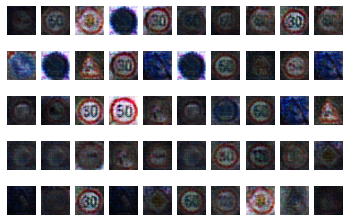

*************************

Epoch # 6.0
Accuracy of the classifier is 88.0 %.
*************************

Epoch # 7.0
Accuracy of the classifier is 88.0 %.
*************************

Epoch # 8.0
Accuracy of the classifier is 90.0 %.
*************************

Epoch # 9.0
Accuracy of the classifier is 90.0 %.
*************************

Epoch # 10.0
Accuracy of the classifier is 90.0 %.


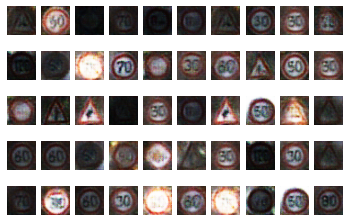

*************************

Epoch # 11.0
Accuracy of the classifier is 91.0 %.
*************************

Epoch # 12.0
Accuracy of the classifier is 89.0 %.
*************************

Epoch # 13.0
Accuracy of the classifier is 91.0 %.
*************************

Epoch # 14.0
Accuracy of the classifier is 91.0 %.
*************************

Epoch # 15.0
Accuracy of the classifier is 91.0 %.


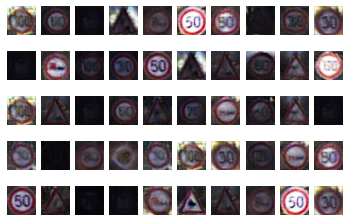

*************************

Epoch # 16.0
Accuracy of the classifier is 92.0 %.
*************************

Epoch # 17.0
Accuracy of the classifier is 91.0 %.
*************************

Epoch # 18.0
Accuracy of the classifier is 92.0 %.
*************************

Epoch # 19.0
Accuracy of the classifier is 91.0 %.
*************************

Epoch # 20.0
Accuracy of the classifier is 92.0 %.


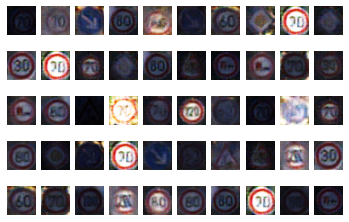

*************************



In [23]:

disc_model, cls_model = make_discriminator()
gen_model = make_generator(noise_dim)
gan_model = make_gan(gen_model, disc_model)

models_list = [gen_model, disc_model, cls_model, gan_model] 

train(models_list, X_train, y_train, noise_dim)

## Evaluating the model on test data

In [24]:
with open('../data/test.pkl','rb') as f:
    X_test,y_test = pickle.load(f)

X_test = np.array(X_test).astype('float32')
X_test = (X_test - 127.5) / 127.5
y_test = np.array(y_test)

Evaluating the classifier on test data

Accuracy of the classifier is 87.0 %.


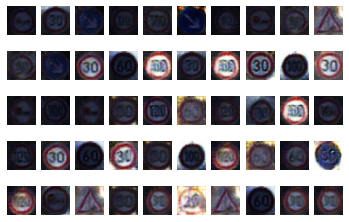

In [25]:
print('Evaluating the classifier on test data')
print()
evaluate_model(5,models_list[2],models_list[0], X_test,y_test)

In [26]:
# save the classifier and gan
model_list[2].save('../models/semisupervised_classifier.h5')
model_list[0].save('../models/semisupervised_gan.h5')